In [21]:
import sys
import os
import numpy as np
import supervision as sv
import math
from matplotlib import pyplot as plt

src_path = os.path.abspath(os.path.join('../../../', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    

from tools.data_processor import DataProcessor
from tools.frame_processors import SupervisionVertexProcessorWithLandmarkFrontalization
from tools.frame_preprocessors import TextureFrontalizationPreprocessor, FaceExtractionPreprocessor

In [22]:
EXPRESSIONS_PATH = os.path.abspath(os.path.join('..', 'data', 'expressions'))
REFERENCE_POINTS = "key_points_xyz.npy"
REFERENCE_POINTS_PATH = os.path.abspath(os.path.join('..', 'data', 'reference_points', REFERENCE_POINTS))
MODELS_PATH = os.path.join(src_path, "models", "frontalization_models")

In [23]:
class SVPWLF_dummy(SupervisionVertexProcessorWithLandmarkFrontalization):
    def __init__(self, reference_points_path: str):
        super().__init__(reference_points_path)
        self.keypoints_history = []
    
    def process(self, frame: np.ndarray) -> np.ndarray:        
        processed_frame = self._model.process(frame)
        image_to_frontalize_xyz = self._get_xyz_from_processed_frame(processed_frame)
        frontalized_keypoints = self._procrustes_analysis(
            image_to_frontalize_xyz[0], self._reference_points[0]
        )
        frontalized_keypoints = self._get_xy_from_xyz(frontalized_keypoints)
        
        self.keypoints_history.append(frontalized_keypoints)

        return self._make_face_mesh(frontalized_keypoints)

In [24]:
class DataProcessor_dummy(DataProcessor):
    def process_video(
        self,
        source_path: str,
        target_path: str = None,
    ):
        """
        Overrides the regular process_video to not display the output frame but rather show
        the accumulated landmark data.

        Args:
            source_path (str): The path to the source video.
            target_path (str): The path to the target video
        """
        for frame in sv.get_video_frames_generator(source_path):
            annotated_frame = self._handle_frame(frame)
            if annotated_frame is None:
                continue
        
        return self._frame_processor.keypoints_history


In [25]:
LANDMARK_INDEXES = [
    76, 206,  # mouth corners
    74, 73, 72, 11, 302, 303, 304, # upper lip
    90, 180, 85, 16, 315, 404, 320, # lower lip
    33, 161, 159, 157, 133, 154, 145, 163,  # left eye
    70, 63, 105, 66, 107,  # left eyebrow
    362, 384, 386, 388, 263, 390, 374, 381,  # right eye
    300, 293, 334, 296, 336,  # right eyebrow
    1, 5, 197, 168  # nose
]

REFERENCE_LANDMARK_INDEX = 0  # Middle of face

def get_average_landmarks_distance(video_path: str):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        distance_sum = 0
        for landmark_idx in LANDMARK_INDEXES:
            distance_sum += math.sqrt(
                (keypoint[REFERENCE_LANDMARK_INDEX][0] - keypoint[landmark_idx][0])**2 +
                (keypoint[REFERENCE_LANDMARK_INDEX][1] - keypoint[landmark_idx][1])**2
            )
        output.append(distance_sum / len(LANDMARK_INDEXES))

    return output

In [26]:
emotions_distance = {}

In [ ]:
for emotion_video in os.listdir(EXPRESSIONS_PATH):
    if emotion not in emotions_distance:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_distance[emotion] = get_average_landmarks_distance(emotion_video)

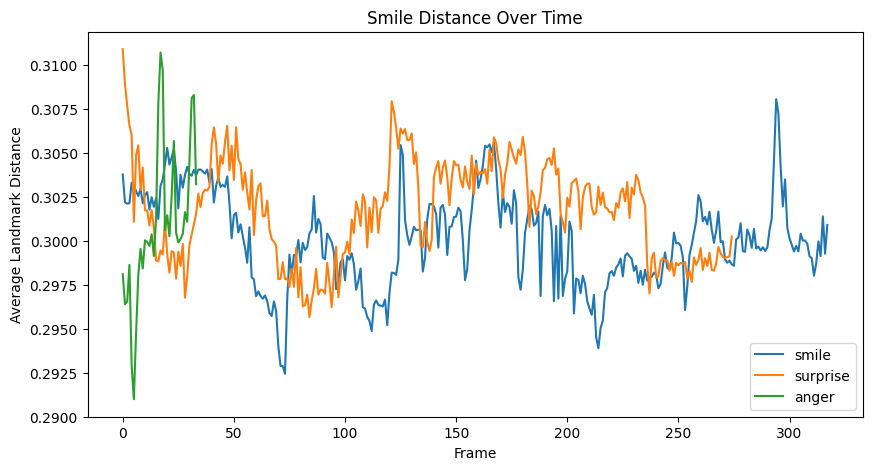

In [28]:
plt.figure(figsize=(10, 5))

for emotion, distances in emotions_distance.items():
    plt.plot(distances, label=emotion)

plt.xlabel('Frame')
plt.ylabel('Average Landmark Distance')
plt.title('Smile Distance Over Time')
plt.legend()
plt.show()